In [1]:
import sys
import os

# Ruta relativa desde el notebook a la carpeta de scripts
sys.path.append(os.path.abspath("../scripts"))

In [2]:
import numpy as np
import pandas as pd
import torch as t
from datasets import Dataset
from dataset_utils import df_to_dataset
import task1_config as config

c:\Users\sdami\OneDrive\Escritorio\Misongyny\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
TASK = "task2"

### Training Dataset

In [ ]:
train_df = pd.read_csv(f"../datasets/sub{TASK}_train_rev002.csv", encoding="utf-8")
train_df.columns

Index(['id', 'lyrics', 'label'], dtype='object')

In [4]:
train_df['label'].unique()

array(['NM', 'M'], dtype=object)

In [ ]:
classmap = { 'NR': 0, 'S': 1, 'V': 2, 'H': 3 } 

train_df['label'] = train_df['label'].apply(lambda x: classmap[x])

In [6]:
train_dataset, con_dict = df_to_dataset(train_df)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_song_hist(songs, quantile=0.95):
    song_lengths = [len(song) for song in songs]
    mean = np.mean(song_lengths)
    quartile = np.quantile(song_lengths, q=quantile)

    print(f"max value: { np.max(song_lengths) }")
    aux = len(song_lengths) * (1-quantile)
    print(f"quantile {quantile}: {aux:.0f} / {len(song_lengths)} ")
    
    plt.hist(song_lengths, bins=np.arange(1, 125, 10))
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean:.2f}')
    plt.axvline(quartile, color='green', linestyle='dashed', linewidth=2, label=f'Quantile {quantile} = {quartile:.2f}')
    plt.title("Number of sentences per song")
    plt.legend()
    plt.show()

def plot_sentence_length(songs, quantile=0.95):
    sentence_lengths = [len(sentence.split(" ")) for song in songs for sentence in song]
    mean = np.mean(sentence_lengths)
    quartile = np.quantile(sentence_lengths, q=quantile)

    print(f"max value: { np.max(sentence_lengths) }")
    aux = len(sentence_lengths) * (1-quantile)
    print(f"quantile {quantile}: {aux:.0f} / {len(sentence_lengths)} ")
    
    plt.hist(sentence_lengths, bins=np.arange(1, 24, 1))
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean:.2f}')
    plt.axvline(quartile, color='green', linestyle='dashed', linewidth=2, label=f'Quantile {quantile} = {quartile:.2f}')
    plt.title("Number of sentences per song")
    plt.legend()
    plt.show()

max value: 271
quantile 0.95: 105 / 2104 


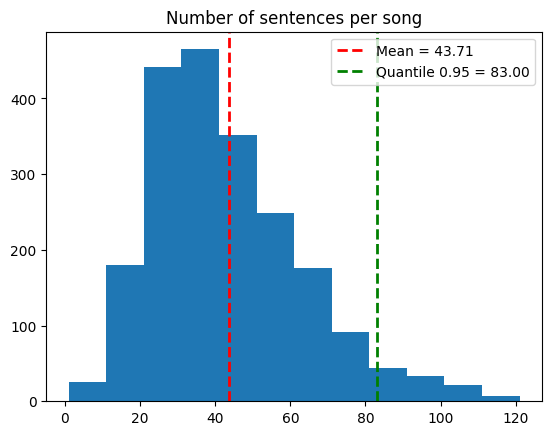

In [8]:
plot_song_hist(train_dataset['songs'], 0.95)

max value: 210
quantile 0.95: 4599 / 91974 


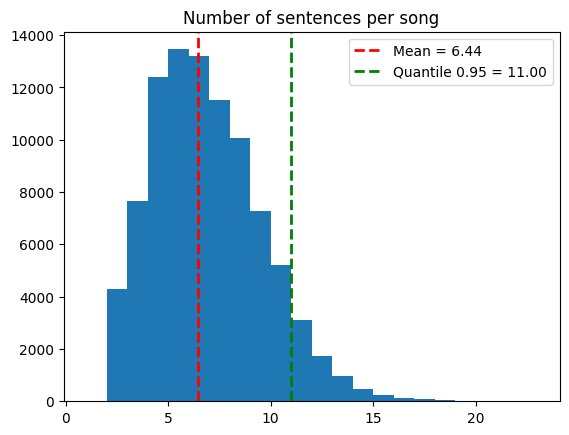

In [9]:
plot_sentence_length(train_dataset['songs'])

In [10]:
idx = 1605

def compare_texts_side_by_side(text1, text2, width=80):
    lines1 = text1.splitlines()
    lines2 = text2.splitlines()
    max_lines = max(len(lines1), len(lines2))
    lines1 += [''] * (max_lines - len(lines1))
    lines2 += [''] * (max_lines - len(lines2))

    for l1, l2 in zip(lines1, lines2):
        print(f"{l1:<{width}} | {l2}")


compare_texts_side_by_side(train_df["lyrics"].iloc[idx], "\n".join(train_dataset['songs'][idx]))

                                                                                 | Yo le lei
[Letra de "El Farolito"]                                                         | Le yo lo lei
                                                                                 | Yo le lei
[Intro]                                                                          | Le yo lo lei
Yo le le lei                                                                     | Veo un farolito en tu cintura
Le yo lo lo lei                                                                  | Veo un farolito en tu cintura
Yo le le lei                                                                     | Cuando tú lo mueves tiembla la luna
Le yo lo lo lei                                                                  | Cuando tú lo mueves tiembla la luna
                                                                                 | Veo un farolito en tu cadera
[Verso 1]                                     

| Version | Descripcion |
|-|-|
| v1 | cada oración de la canción individual |
| v2 | eliminar oraciones en inglés |
| v3 | eliminar oraciones repetidas (unique) |
| v4 | eliminar oraciones repetidas consecutivas |
| v5 | grupos de oraciones |
| v6 | grupos de oraciones traslapadas |

In [ ]:
train_dataset.save_to_disk(f'../datasets/{TASK}_mil_v1')

Saving the dataset (1/1 shards): 100%|██████████| 2104/2104 [00:00<00:00, 110721.25 examples/s]


### Test Set

In [ ]:
test_df = pd.read_csv(f"../datasets/{TASK}_public_test_rev002.csv", encoding="utf-8")
test_df.columns

Index(['id', 'lyrics'], dtype='object')

In [13]:
test_dataset, _ = df_to_dataset(test_df, columns=test_df.columns, contractions_dict=con_dict)

max value: 243
quantile 0.95: 26 / 527 


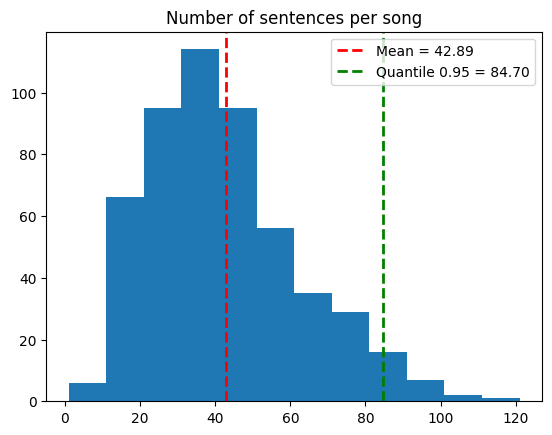

In [14]:
plot_song_hist(test_dataset['songs'])

max value: 154
quantile 0.95: 1130 / 22602 


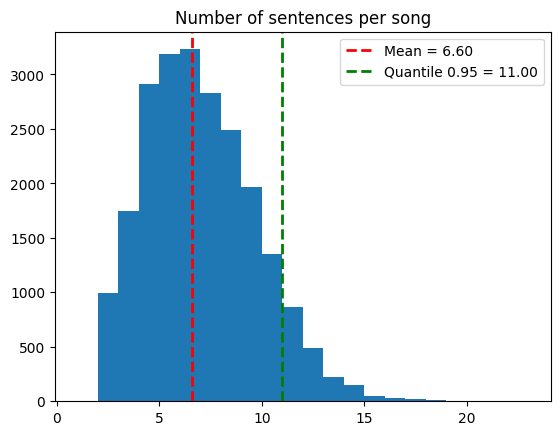

In [15]:
plot_sentence_length(test_dataset['songs'])

In [ ]:
test_dataset.save_to_disk(f'../datasets/{TASK}_mil_v1_test')

Saving the dataset (1/1 shards): 100%|██████████| 527/527 [00:00<00:00, 47908.41 examples/s]
